# Machine Learning Project
Topic:
> A model that can recognize people and classify if they wear masks properly.


Team Members:


> Changhe Chen 

> Ziang Zhang



## Import Libraries

In [ ]:
# import the potential libraries needed
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from  torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from  google.colab import drive
import torchvision.models
import os
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load Datasets

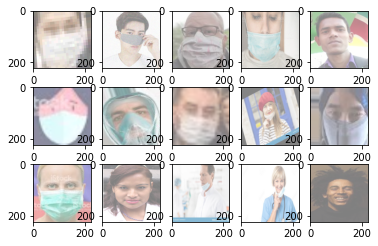

In [ ]:
# Load the data from google drive
# Compose a list of transforms together.
# Resize all images to 224-by-224 pixels.
trans = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# Define dataset addresses
valPath = '/content/gdrive/My Drive/Machine_learning_project/mask_detection/validation/'
testPath = '/content/gdrive/My Drive/Machine_learning_project/mask_detection/test/'
trainPath = '/content/gdrive/My Drive/Machine_learning_project/mask_detection/train/'

# Create data loaders for training, validation, and test datasets
valData = torchvision.datasets.ImageFolder(root = valPath, transform = trans)
testData = torchvision.datasets.ImageFolder(root = testPath, transform = trans)
trainData = torchvision.datasets.ImageFolder(root = trainPath, transform = trans)

trainLoader = torch.utils.data.DataLoader(trainData, batch_size = 64, num_workers = 1, shuffle = True)
testLoader = torch.utils.data.DataLoader(testData, batch_size = 64, num_workers = 1, shuffle = True)
valLoader = torch.utils.data.DataLoader(valData, batch_size = 64, num_workers = 1, shuffle = True)

# Binary classification
classes = ['without_incorrect_mask', 'with_mask']

# check if the pics are loaded
i = 0
for img, lab in trainLoader:
  image = img[0]
  # from tensor to standard image format for showing purpose
  imgs = np.transpose(image, [1,2,0])
  # 50% transparency  
  imgs = imgs / 2 + 0.5
  plt.subplot(3, 5, i+1)
  plt.axis('on')
  plt.imshow(imgs)

  i = i + 1
  if i > 14:
    break

In [ ]:
# train:val:test = 70:15:15
print("Number of pictures in train dataset: " + str(len(trainData)))
print("Number of pictures in validation dataset: " + str(len(valData)))
print("Number of pictures in test dataset: "+ str(len(testData)))

Number of pictures in train dataset: 1975
Number of pictures in validation dataset: 412
Number of pictures in test dataset: 377


In [ ]:
# Using alexnet to extract features for every single 

alexnet = torchvision.models.alexnet(pretrained=True)

trainLoaderFea = torch.utils.data.DataLoader(trainData, batch_size = 1, num_workers = 1, shuffle = True)
testLoaderFea = torch.utils.data.DataLoader(testData, batch_size = 1, num_workers = 1, shuffle = True)
valLoaderFea = torch.utils.data.DataLoader(valData, batch_size = 1, num_workers = 1, shuffle = True)


i = 0
for img, label in testLoaderFea:
  features = alexnet.features(img)
  featureTensor = torch.from_numpy(features.detach().numpy())
  folder = '/content/gdrive/My Drive/Machine_learning_project/mask_detection/testFeature/'+str(classes[label])
  if not os.path.isdir(folder):
    os.mkdir(folder)

  # Test original img dimension
  if i == 0:
    print("Original Feature Shape: ",featureTensor.shape)

  # squeeze AlexNet output first dimension
  
  torch.save(featureTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  i = i + 1
print("testFeature done")
print("Feature Shape: ",featureTensor.squeeze(0).shape)


i = 0
for img, label in valLoaderFea:
  features = alexnet.features(img)
  featureTensor = torch.from_numpy(features.detach().numpy())
  folder ='/content/gdrive/My Drive/Machine_learning_project/mask_detection/valFeature/'+str(classes[label])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featureTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  i = i+1

print("valFeature done")
print("Feature Shape: ",featureTensor.squeeze(0).shape)


i = 0
for img, label in trainLoaderFea:
  features = alexnet.features(img)
  featureTensor = torch.from_numpy(features.detach().numpy())
  folder='/content/gdrive/My Drive/Machine_learning_project/mask_detection/trainFeature/'+str(classes[label])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featureTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  i = i+1

print("trainFeature done")
print("Feature Shape: ",featureTensor.squeeze(0).shape)

Original Feature Shape:  torch.Size([1, 256, 6, 6])
testFeature done
Feature Shape:  torch.Size([256, 6, 6])
valFeature done
Feature Shape:  torch.Size([256, 6, 6])
trainFeature done
Feature Shape:  torch.Size([256, 6, 6])


In [ ]:
# Getting dataloader for the tensors
trainFeaPath = '/content/gdrive/My Drive/Machine_learning_project/mask_detection/trainFeature/'
valFeaPath = '/content/gdrive/My Drive/Machine_learning_project/mask_detection/valFeature/'
testFeaPath = '/content/gdrive/My Drive/Machine_learning_project/mask_detection/testFeature/'

trainFeatures = torchvision.datasets.DatasetFolder(trainFeaPath, loader=torch.load, extensions=('.tensor'))
valFeatures = torchvision.datasets.DatasetFolder(valFeaPath, loader=torch.load, extensions=('.tensor'))
testFeatures = torchvision.datasets.DatasetFolder(testFeaPath, loader=torch.load, extensions=('.tensor'))

trainFeaLoader = torch.utils.data.DataLoader(trainFeatures, batch_size=256, num_workers=1, shuffle=True)
valFeaLoader = torch.utils.data.DataLoader(valFeatures, batch_size=256, num_workers=1, shuffle=True)
testFeaLoader = torch.utils.data.DataLoader(testFeatures, batch_size=256, num_workers=1, shuffle=True)

##  Part 1 Primary Model (Mask Detection)

In [ ]:
# CNN architechture
# input channel = 256;
class CNNWithAlex(nn.Module):
    def __init__(self):
        super(CNNWithAlex, self).__init__()     # [(W−K+2P)/S]+1
        self.name = "CNNWithAlex"               
        self.conv1 = nn.Conv2d(256, 64, 2)    # 256*6*6 -> 64*5*5
        self.conv2 = nn.Conv2d(64, 8, 2)     # 64*5*5 -> 8*4*4
        self.fc1 = nn.Linear(8*4*4, 32)          
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # 256*8*4*4 -> 256*(8*4*4)
        x = x.view(-1, 8*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # 256*(8*4*4)-> 8*4*4
        x = x.squeeze(1)
        return x



In [ ]:
# Helper functions needed for trainning

def get_model_name(name, batch_size, learning_rate, epoch):
    """ 
    Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,batch_size, learning_rate, epoch)
    return path
  
def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels


def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader 
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the test set
         loss: A scalar for the average loss function over the test set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0): # start enumerating from 0 until loader-1
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    acc = 1 - err
    loss = float(total_loss) / (i + 1)
    return acc, loss

In [ ]:
# Trainning code function
def train(net, trainLoader, valLoader, batchSize=64, learningRate=0.001, numEpochs=1):
    
    torch.manual_seed(1000) 
    # Binary Cross Entropy
    criterion = nn.BCEWithLogitsLoss() 
    # stochastic gradient descent optimizer
    optimizer = optim.SGD(net.parameters(), lr=learningRate, momentum=0.9) 

    
    totalLoss = []
    trainAccr = [] 
    valAccr = [] 
    iteration = []

    it = 0 
    for epoch in range(numEpochs):
      for img, label in iter(trainLoader):

        if torch.cuda.is_available():
          img = img.cuda()
          labels = label.cuda()
         
        label = normalize_label(label)
        optimizer.zero_grad()

        output = net(img)           
        loss = criterion(output, label.float())
        loss.backward()               
        optimizer.step() 
        optimizer.zero_grad()              
      
      
      currentTErr, currentTLoss = evaluate(net, trainLoader, criterion)
      currentVErr, currentVLoss = evaluate(net, valLoader, criterion)

      trainAccr.append(currentTErr)
      valAccr.append(currentVErr)
      totalLoss.append(currentVLoss)
      iteration.append(it)

      path = get_model_name(net.name, batchSize, learningRate, epoch)
      torch.save(net.state_dict(), path)

      it = it + 1        
      print("train accuracy: " + str(currentTErr) + "|val accuracy: "+ str(currentVErr))

    plt.plot(iteration, trainAccr)
    plt.title("Training")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.show()

    plt.plot(iteration, valAccr)
    plt.title("Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.show()

train accuracy: 0.5417721518987342|val accuracy: 0.5145631067961165
train accuracy: 0.610632911392405|val accuracy: 0.5703883495145632
train accuracy: 0.6850632911392405|val accuracy: 0.6310679611650485
train accuracy: 0.7488607594936709|val accuracy: 0.6601941747572815
train accuracy: 0.7939240506329114|val accuracy: 0.7087378640776699
train accuracy: 0.8040506329113923|val accuracy: 0.7087378640776699
train accuracy: 0.7989873417721519|val accuracy: 0.7087378640776699
train accuracy: 0.7888607594936708|val accuracy: 0.6990291262135923
train accuracy: 0.7681012658227848|val accuracy: 0.6796116504854368
train accuracy: 0.7645569620253164|val accuracy: 0.6796116504854368
train accuracy: 0.769620253164557|val accuracy: 0.6796116504854368
train accuracy: 0.7812658227848102|val accuracy: 0.6941747572815534
train accuracy: 0.8060759493670886|val accuracy: 0.7160194174757282
train accuracy: 0.8324050632911393|val accuracy: 0.7427184466019418
train accuracy: 0.8637974683544304|val accuracy: 0

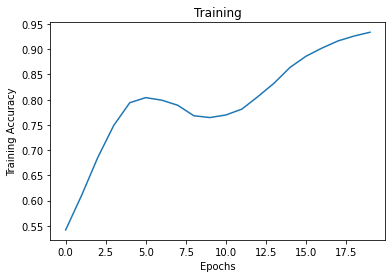

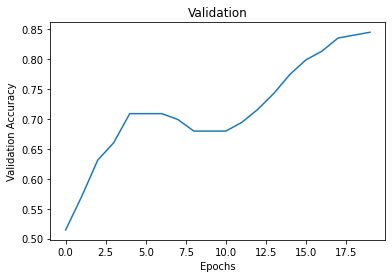

In [ ]:
# Trainning CNN here
alex=CNNWithAlex()
trainFeaLoader = torch.utils.data.DataLoader(trainFeatures, batch_size=256, num_workers=1, shuffle=True)
valFeaLoader = torch.utils.data.DataLoader(valFeatures, batch_size=256, num_workers=1, shuffle=True)
train(alex, trainFeaLoader, valFeaLoader, 256, 0.001, 20)

train accuracy: 0.5007594936708861|val accuracy: 0.5072815533980582
train accuracy: 0.5007594936708861|val accuracy: 0.5097087378640777
train accuracy: 0.5022784810126582|val accuracy: 0.5169902912621359
train accuracy: 0.5108860759493671|val accuracy: 0.5315533980582524
train accuracy: 0.549367088607595|val accuracy: 0.5776699029126213
train accuracy: 0.6263291139240506|val accuracy: 0.6310679611650485
train accuracy: 0.7184810126582278|val accuracy: 0.6868932038834952
train accuracy: 0.8040506329113923|val accuracy: 0.7257281553398058
train accuracy: 0.8526582278481013|val accuracy: 0.7305825242718447
train accuracy: 0.8627848101265823|val accuracy: 0.7524271844660194


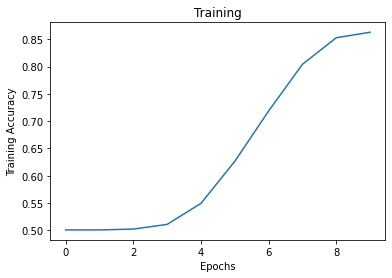

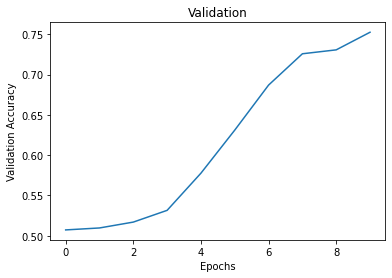

In [ ]:
# Trainning CNN here
alex0=CNNWithAlex()
trainFeaLoader = torch.utils.data.DataLoader(trainFeatures, batch_size=512, num_workers=1, shuffle=True)
valFeaLoader = torch.utils.data.DataLoader(valFeatures, batch_size=512, num_workers=1, shuffle=True)
train(alex0, trainFeaLoader, valFeaLoader, 512, 0.001, 10)

train accuracy: 0.499746835443038|val accuracy: 0.49271844660194175
train accuracy: 0.8865822784810127|val accuracy: 0.8106796116504854
train accuracy: 0.9149367088607595|val accuracy: 0.8446601941747574
train accuracy: 0.9346835443037975|val accuracy: 0.8446601941747574
train accuracy: 0.9574683544303797|val accuracy: 0.8786407766990292
train accuracy: 0.9762025316455696|val accuracy: 0.9029126213592233
train accuracy: 0.980253164556962|val accuracy: 0.9101941747572816
train accuracy: 0.9888607594936709|val accuracy: 0.9101941747572816
train accuracy: 0.9913924050632912|val accuracy: 0.9077669902912622
train accuracy: 0.9939240506329113|val accuracy: 0.9150485436893204
train accuracy: 0.9944303797468355|val accuracy: 0.9174757281553398
train accuracy: 0.9954430379746836|val accuracy: 0.9223300970873787
train accuracy: 0.9974683544303797|val accuracy: 0.9174757281553398
train accuracy: 0.9979746835443037|val accuracy: 0.9247572815533981
train accuracy: 0.9984810126582279|val accuracy: 

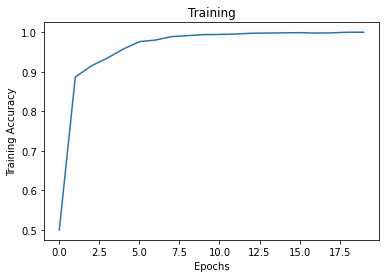

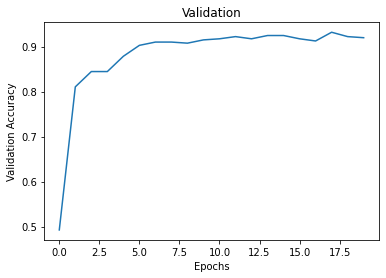

In [ ]:
# Trainning CNN here
alex1=CNNWithAlex()
trainFeaLoader = torch.utils.data.DataLoader(trainFeatures, batch_size=256, num_workers=1, shuffle=True)
valFeaLoader = torch.utils.data.DataLoader(valFeatures, batch_size=256, num_workers=1, shuffle=True)
train(alex1, trainFeaLoader, valFeaLoader, 256, 0.01, 20)

train accuracy: 0.5969620253164557|val accuracy: 0.6067961165048543
train accuracy: 0.8075949367088607|val accuracy: 0.6820388349514563
train accuracy: 0.6415189873417722|val accuracy: 0.5315533980582524
train accuracy: 0.8521518987341772|val accuracy: 0.7572815533980582
train accuracy: 0.909367088607595|val accuracy: 0.8203883495145631
train accuracy: 0.9372151898734177|val accuracy: 0.8470873786407767
train accuracy: 0.9443037974683545|val accuracy: 0.8616504854368932
train accuracy: 0.9524050632911393|val accuracy: 0.866504854368932
train accuracy: 0.9635443037974684|val accuracy: 0.854368932038835
train accuracy: 0.9762025316455696|val accuracy: 0.8567961165048543
train accuracy: 0.9837974683544304|val accuracy: 0.8810679611650485
train accuracy: 0.9873417721518988|val accuracy: 0.8810679611650485
train accuracy: 0.9868354430379747|val accuracy: 0.8762135922330097
train accuracy: 0.990379746835443|val accuracy: 0.8859223300970873
train accuracy: 0.9918987341772152|val accuracy: 0.8

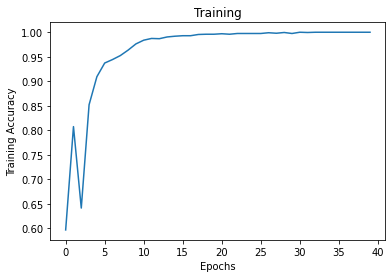

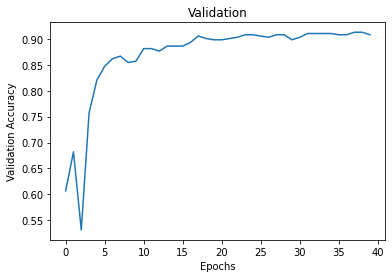

In [ ]:
# Trainning CNN here
newalex=CNNWithAlex()
trainFeaLoader = torch.utils.data.DataLoader(trainFeatures, batch_size=256, num_workers=1, shuffle=True)
valFeaLoader = torch.utils.data.DataLoader(valFeatures, batch_size=256, num_workers=1, shuffle=True)
train(newalex, trainFeaLoader, valFeaLoader, 256, 0.005, 40)

train accuracy: 0.500253164556962|val accuracy: 0.5072815533980582
train accuracy: 0.500253164556962|val accuracy: 0.5072815533980582
train accuracy: 0.500253164556962|val accuracy: 0.5072815533980582
train accuracy: 0.500253164556962|val accuracy: 0.5072815533980582
train accuracy: 0.5053164556962025|val accuracy: 0.5097087378640777
train accuracy: 0.5878481012658228|val accuracy: 0.6019417475728155
train accuracy: 0.7225316455696202|val accuracy: 0.7135922330097088
train accuracy: 0.8146835443037974|val accuracy: 0.808252427184466
train accuracy: 0.8875949367088608|val accuracy: 0.8689320388349515
train accuracy: 0.9083544303797468|val accuracy: 0.8689320388349515
train accuracy: 0.9063291139240506|val accuracy: 0.866504854368932
train accuracy: 0.9210126582278481|val accuracy: 0.866504854368932
train accuracy: 0.9240506329113924|val accuracy: 0.866504854368932
train accuracy: 0.9326582278481013|val accuracy: 0.8689320388349515
train accuracy: 0.9372151898734177|val accuracy: 0.87135

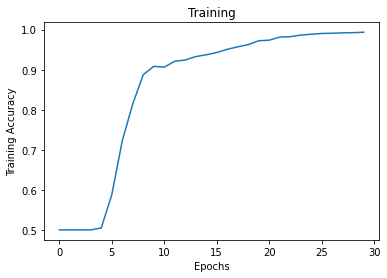

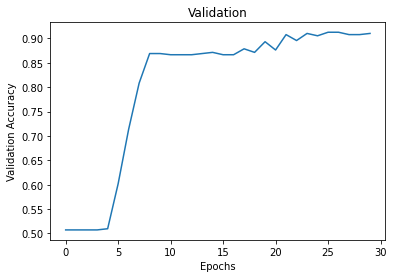

In [ ]:
# Trainning CNN here
anotheralex=CNNWithAlex()
trainFeaLoader = torch.utils.data.DataLoader(trainFeatures, batch_size=512, num_workers=1, shuffle=True)
valFeaLoader = torch.utils.data.DataLoader(valFeatures, batch_size=512, num_workers=1, shuffle=True)
train(anotheralex, trainFeaLoader, valFeaLoader, 512, 0.005, 30)

In [ ]:
criterion = nn.BCEWithLogitsLoss() 
testFeaLoader = torch.utils.data.DataLoader(testFeatures, batch_size=256, num_workers=1, shuffle=True)
print (evaluate(alex1, testFeaLoader, criterion))
print (evaluate(newalex, testFeaLoader, criterion))
print (evaluate(anotheralex, testFeaLoader, criterion))


(0.728952772073922, 1.8504292368888855)
(0.7084188911704312, 2.141127347946167)
(0.728952772073922, 1.0247476398944855)


## Part 2 Primary Model (Facial Recognition)

In [ ]:
"""
People detection starts below

"""

'\nPeople detection starts below\n\n'

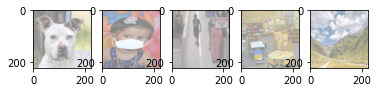

In [ ]:
# Load the data from google drive 
# Compose a list of transforms together.
# Resize all images to 224-by-224 pixels.
trans = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# Define dataset addresses
valPplPath = '/content/gdrive/My Drive/Machine_learning_project/face_detection/validate/'
testPplPath = '/content/gdrive/My Drive/Machine_learning_project/face_detection/test/'
trainPplPath = '/content/gdrive/My Drive/Machine_learning_project/face_detection/train/'

# Create data loaders for training, validation, and test datasets
valPplData = torchvision.datasets.ImageFolder(root = valPplPath, transform = trans)
testPplData = torchvision.datasets.ImageFolder(root = testPplPath, transform = trans)
trainPplData = torchvision.datasets.ImageFolder(root = trainPplPath, transform = trans)

trainPplLoader = torch.utils.data.DataLoader(trainPplData, batch_size = 64, num_workers = 1, shuffle = True)
testPplLoader = torch.utils.data.DataLoader(testPplData, batch_size = 64, num_workers = 1, shuffle = True)
valPplLoader = torch.utils.data.DataLoader(valPplData, batch_size = 64, num_workers = 1, shuffle = True)

# Binary classification
classes = ['no_human_face_test', 'human_face_test']

# check if the pics are loaded
i = 0
for img, lab in trainPplLoader:
  image = img[0]
  imgs = np.transpose(image, [1,2,0])  
  imgs = imgs / 2 + 0.5
  plt.subplot(3, 5, i+1)
  plt.axis('on')
  plt.imshow(imgs)

  i = i + 1
  if i > 4:
    break

In [ ]:
print("Number of pictures in train dataset: " + str(len(trainPplData)))
print("Number of pictures in validation dataset: " + str(len(valPplData)))
print("Number of pictures in test dataset: "+ str(len(testPplData)))

Number of pictures in train dataset: 2009
Number of pictures in validation dataset: 427
Number of pictures in test dataset: 415


In [ ]:
# Using alexnet to extract features

alexnetPpl = torchvision.models.alexnet(pretrained=True)

trainPplLoaderFea = torch.utils.data.DataLoader(trainPplData, batch_size = 1, num_workers = 1, shuffle = True)
testPplLoaderFea = torch.utils.data.DataLoader(testPplData, batch_size = 1, num_workers = 1, shuffle = True)
valPplLoaderFea = torch.utils.data.DataLoader(valPplData, batch_size = 1, num_workers = 1, shuffle = True)


i = 0
for img, label in testPplLoaderFea:
  features = alexnetPpl.features(img)
  featureTensor = torch.from_numpy(features.detach().numpy())
  folder = '/content/gdrive/My Drive/Machine_learning_project/face_detection/testFeature/'+str(classes[label])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featureTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  #print(featureTensor.squeeze(0).shape)
  i = i + 1


i = 0
for img, label in valPplLoaderFea:
  features = alexnetPpl.features(img)
  featureTensor = torch.from_numpy(features.detach().numpy())
  folder ='/content/gdrive/My Drive/Machine_learning_project/face_detection/valFeature/'+str(classes[label])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featureTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  i = i+1


i = 0
for img, label in trainPplLoaderFea:
  features = alexnetPpl.features(img)
  featureTensor = torch.from_numpy(features.detach().numpy())
  folder='/content/gdrive/My Drive/Machine_learning_project/face_detection/trainFeature/'+str(classes[label])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featureTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  i = i+1


In [ ]:
trainFeaPathPpl = '/content/gdrive/My Drive/Machine_learning_project/face_detection/trainFeature/'
valFeaPathPpl = '/content/gdrive/My Drive/Machine_learning_project/face_detection/valFeature/'
testFeaPathPpl = '/content/gdrive/My Drive/Machine_learning_project/face_detection/testFeature/'

trainPplFeatures = torchvision.datasets.DatasetFolder(trainFeaPathPpl, loader=torch.load, extensions=('.tensor'))
valPplFeatures = torchvision.datasets.DatasetFolder(valFeaPathPpl, loader=torch.load, extensions=('.tensor'))
testPplFeatures = torchvision.datasets.DatasetFolder(testFeaPathPpl, loader=torch.load, extensions=('.tensor'))

trainPplFeaLoader = torch.utils.data.DataLoader(trainPplFeatures, batch_size=256, num_workers=1, shuffle=True)
valPplFeaLoader = torch.utils.data.DataLoader(valPplFeatures, batch_size=256, num_workers=1, shuffle=True)
testPplFeaLoader = torch.utils.data.DataLoader(testPplFeatures, batch_size=256, num_workers=1, shuffle=True)

In [ ]:
# CNN architechture
class CNNWithAlexPpl(nn.Module):
    def __init__(self):
        super(CNNWithAlexPpl, self).__init__()
        self.name = "CNNWithAlexPpl"
        self.conv1 = nn.Conv2d(256, 64, 2)
        self.conv2 = nn.Conv2d(64, 8, 2)
        self.fc1 = nn.Linear(8*4*4, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 8*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

train accuracy: 0.5574912891986064|val accuracy: 0.5269320843091334
train accuracy: 0.6137381781981085|val accuracy: 0.6042154566744731
train accuracy: 0.6779492284718766|val accuracy: 0.6697892271662764
train accuracy: 0.7436535589845694|val accuracy: 0.7470725995316159
train accuracy: 0.8143354902936785|val accuracy: 0.819672131147541
train accuracy: 0.8656047784967645|val accuracy: 0.8899297423887588
train accuracy: 0.879044300647088|val accuracy: 0.9156908665105387
train accuracy: 0.8745644599303136|val accuracy: 0.9227166276346604
train accuracy: 0.8685913389746143|val accuracy: 0.9227166276346604
train accuracy: 0.8710801393728222|val accuracy: 0.936768149882904
train accuracy: 0.8845196615231459|val accuracy: 0.9414519906323185
train accuracy: 0.9014435042309606|val accuracy: 0.955503512880562
train accuracy: 0.9223494275759084|val accuracy: 0.9718969555035128
train accuracy: 0.9427575908412146|val accuracy: 0.9742388758782201
train accuracy: 0.9507217521154804|val accuracy: 0.9

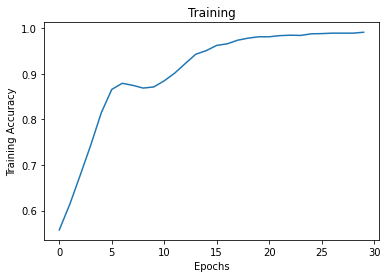

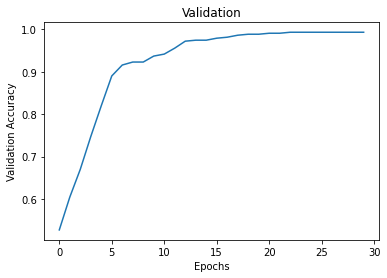

In [ ]:
alexPpl=CNNWithAlexPpl()
trainPplFeaLoader = torch.utils.data.DataLoader(trainPplFeatures, batch_size=256, num_workers=1, shuffle=True)
valPplFeaLoader = torch.utils.data.DataLoader(valPplFeatures, batch_size=256, num_workers=1, shuffle=True)
train(alexPpl, trainPplFeaLoader, valPplFeaLoader, 256, 0.001, 30)

In [ ]:
criterion = nn.BCEWithLogitsLoss() 
print (evaluate(alexPpl, testPplFeaLoader, criterion))

(0.9879518072289156, 0.08213888481259346)


**Model Combination**

In [ ]:
# import the potential libraries needed
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
import torchvision.models
import os
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model_face = CNNWithAlexPpl()
model_face_path = '/content/gdrive/My Drive/Machine_learning_project/Models/Face_detection_model/model_CNNWithAlexPpl_bs256_lr0.001_epoch29'
state_face = torch.load(model_face_path)
model_face.load_state_dict(state_face)

model_mask = CNNWithAlex()
model_mask_path = '/content/gdrive/My Drive/Machine_learning_project/Models/Mask_detection_model/model_CNNWithAlex_bs512_lr0.005_epoch29'
state_mask = torch.load(model_mask_path)
model_mask.load_state_dict(state_mask)

<All keys matched successfully>

# People with masks:

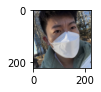

In [ ]:
trans = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

imagePath = '/content/gdrive/My Drive/Machine_learning_project/final_test_with_mask/' # This folder should contain only one image to be evaluated

imageData = torchvision.datasets.ImageFolder(root = imagePath, transform = trans)

imageLoader = torch.utils.data.DataLoader(imageData, batch_size = 64, num_workers = 1, shuffle = True)

# Binary classification
classes = ['without_incorrect_mask', 'with_mask']

# check if the pics are loaded
i = 0
for img, lab in imageLoader:
  image = img[0]
  imgs = np.transpose(image, [1,2,0])  
  plt.subplot(3, 5, i+1)
  plt.axis('on')
  plt.imshow(imgs)

  i = i + 1
  if i > 4:
    break

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)

imageLoaderFea = torch.utils.data.DataLoader(imageData, batch_size = 1, num_workers = 1, shuffle = True)

i = 0
img_feature = torch.tensor
for img, label in imageLoaderFea:
  features = alexnet.features(img)
  featureTensor = torch.from_numpy(features.detach().numpy())
  img_feature = featureTensor
  print(img_feature.shape)
  folder='/content/gdrive/My Drive/Machine_learning_project/Image_Feature/with_mask'
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featureTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  i = i+1

torch.Size([1, 256, 6, 6])


In [ ]:
pred_face = model_face(img_feature)

if pred_face.item()<0:
  print("No human face detected")
else:
  pred_mask = model_mask(img_feature)
  if pred_mask.item()<0:
    print("Please put on your masks/wear your masks correctly")
  else:
    print("Mask correctly wear. Welcome!")

Mask correctly wear. Welcome!


# People without masks:

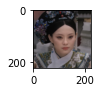

In [ ]:
trans = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

imagePath = '/content/gdrive/My Drive/Machine_learning_project/final_test_without_mask/' # This folder should contain only one image to be evaluated

imageData = torchvision.datasets.ImageFolder(root = imagePath, transform = trans)

imageLoader = torch.utils.data.DataLoader(imageData, batch_size = 64, num_workers = 1, shuffle = True)

# Binary classification
classes = ['without_incorrect_mask', 'with_mask']

# check if the pics are loaded
i = 0
for img, lab in imageLoader:
  image = img[0]
  imgs = np.transpose(image, [1,2,0])  
  plt.subplot(3, 5, i+1)
  plt.axis('on')
  plt.imshow(imgs)

  i = i + 1
  if i > 4:
    break

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)

imageLoaderFea = torch.utils.data.DataLoader(imageData, batch_size = 1, num_workers = 1, shuffle = True)

i = 0
img_feature = torch.tensor
for img, label in imageLoaderFea:
  features = alexnet.features(img)
  featureTensor = torch.from_numpy(features.detach().numpy())
  img_feature = featureTensor
  print(img_feature.shape)
  folder='/content/gdrive/My Drive/Machine_learning_project/Image_Feature/without_mask'
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featureTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  i = i+1

torch.Size([1, 256, 6, 6])


In [ ]:
pred_face = model_face(img_feature)

if pred_face.item()<0:
  print("No human face detected")
else:
  pred_mask = model_mask(img_feature)
  if pred_mask.item()<0:
    print("Please put on your masks/wear your masks correctly")
  else:
    print("Mask correctly wear. Welcome!")

Please put on your masks/wear your masks correctly


# No human detected:

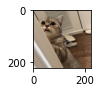

In [ ]:
trans = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

imagePath = '/content/gdrive/My Drive/Machine_learning_project/final_test_not_people/' # This folder should contain only one image to be evaluated

imageData = torchvision.datasets.ImageFolder(root = imagePath, transform = trans)

imageLoader = torch.utils.data.DataLoader(imageData, batch_size = 64, num_workers = 1, shuffle = True)

# Binary classification
classes = ['without_incorrect_mask', 'with_mask']

# check if the pics are loaded
i = 0
for img, lab in imageLoader:
  image = img[0]
  imgs = np.transpose(image, [1,2,0])  
  plt.subplot(3, 5, i+1)
  plt.axis('on')
  plt.imshow(imgs)

  i = i + 1
  if i > 4:
    break

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)

imageLoaderFea = torch.utils.data.DataLoader(imageData, batch_size = 1, num_workers = 1, shuffle = True)

i = 0
img_feature = torch.tensor
for img, label in imageLoaderFea:
  features = alexnet.features(img)
  featureTensor = torch.from_numpy(features.detach().numpy())
  img_feature = featureTensor
  print(img_feature.shape)
  folder='/content/gdrive/My Drive/Machine_learning_project/Image_Feature/not_people'
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featureTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  i = i+1

torch.Size([1, 256, 6, 6])


In [ ]:
pred_face = model_face(img_feature)

if pred_face.item()<0:
  print("No human face detected")
else:
  pred_mask = model_mask(img_feature)
  if pred_mask.item()<0:
    print("Please put on your masks/wear your masks correctly")
  else:
    print("Mask correctly wear. Welcome!")

No human face detected
